In [91]:
import numpy as np
import scipy
from numpy import pi, sqrt, cos, sin, exp, real, imag
import matplotlib.pyplot as plt


In [92]:
A = 0.72
H = 7.12 
L = 8e3

r = 0.3

a_r = 0.1
dL = 0

g = 9.81
sigma = 1.4e-4

epsilon = A / H
eta = sigma * L / sqrt(g * H)
U = epsilon * sigma * L
kappa = g * H / (sigma * L) ** 2

In [93]:
x_x = np.linspace(0, 1+dL, 1000)

factor = 1
h_fx = lambda x: factor * x
h_fx_dx = lambda x: factor
h_fx_dxx = lambda x: 0

In [94]:

h_x, h_x_dx = h_fx(x_x), h_fx_dx(x_x)

# helper functions that often appear
s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

# leading order
eta0_x = 0.5 * (1 + s1_x)
eta0_x_dx = 0.5 * s1_x_dx
Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx


In [95]:

A = Y0_x * eta0_x
B = 2 * Y0_x_dx * eta0_x - Y0_x * eta0_x_dx
C = np.gradient(Y0_x_dx, x_x) * eta0_x - Y0_x_dx * eta0_x_dx
D = - eta0_x**2 * r / kappa / Y0_x
E = - eta0_x**2 / kappa

F = C + D + E


In [96]:
# complex system of equations:

def deriv(x_x, y_x):
    h_x, h_x_dx = h_fx(x_x), h_fx_dx(x_x)

    # helper functions that often appear
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx

    A = Y0_x * eta0_x
    B = 2 * Y0_x_dx * eta0_x - Y0_x * eta0_x_dx
    C = np.gradient(Y0_x_dx, x_x) * eta0_x - Y0_x_dx * eta0_x_dx
    D = - eta0_x**2 * r / kappa / Y0_x
    E = - eta0_x**2 / kappa

    F = C + D + E

    u_x, u_x_dx = y_x
    u_x_dxx = -1 / A * (B * u_x_dx + (C + D * 1j - E) * u_x)
    return [u_x_dx, u_x_dxx]

def bc(yl, yr):
    u_l, u_l_dx = yl
    u_r, u_r_dx = yr
    return [(Y0_x_dx[0] * u_l + Y0_x[0] * u_l_dx) / eta0_x[0]-1j, u_r]

    # return [u_l - 0.005 + 0.99j, u_r]


y_guess = 0.1 * np.ones((2, len(x_x))) + 0.1j * np.ones((2, len(x_x)))


sol = scipy.integrate.solve_bvp(deriv, bc, x_x, y_guess, tol=1e-7, max_nodes=20000, verbose=2)



   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.46e-01       7.72e-01         1000           1998      
       2          4.78e-01       5.97e-01         2998           5994      
       3          5.28e-01       4.61e-01         8992          (17982)    
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 5.28e-01 
Maximum boundary residual: 4.61e-01


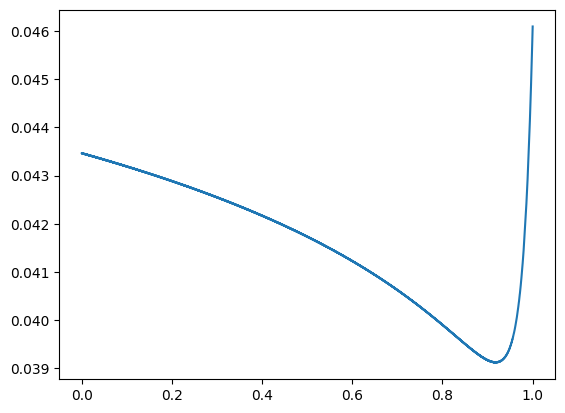

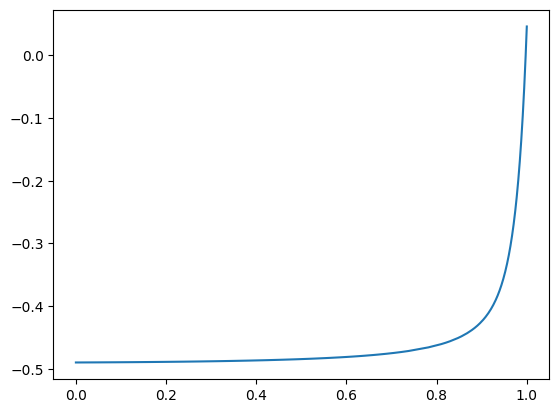

In [97]:
x = sol.x
u_x, u_x_dx = sol.y 

uc_x = real(u_x)
us_x = imag(u_x)

plt.plot(x, uc_x)
plt.show()
plt.plot(x, us_x)
plt.show()



In [98]:
# compare the deriv with the original


# lets consider the following choice:

dzc, dzs, uc, us = 0.5, 0.7, 0.9, 0.3

# at the point x = 0.4




u = uc - 1j * us
dz = uc - 1j * dzs

# we can use the formula to compute uc_dx from dz_s
u_dx = (- eta0_x * 1j * dz - Y0_x_dx * u) / Y0_x


der = deriv(x_x, [u, u_dx])

print([derv[450] for derv in der])




[np.complex128(0.3639344262295084-2.1836065573770496j), np.complex128(1.3004227886530562-7.921036047422922j)]


In [99]:
from pdswe import PDSWE


pdswe = PDSWE()
pdswe.H = 7.12
pdswe.A = 0.72
pdswe.L = 8e3
pdswe.r = 0.3

pdswe.tol = 1e-5

pdswe.a_r = 0.1
pdswe.dL = 0

pdswe.set_derivative_vars()

der = pdswe.deriv_LO(x_x, [dzc, dzs, uc, us])
print([derv[450] for derv in der])


[np.float64(-0.014211322927105143), np.float64(0.013222094730811929), np.float64(0.36393442622950833), np.float64(1.4557377049180331)]


# Even different way

Still use both zeta and u, but make them both complex

In [100]:
# complex system of equations:

def deriv(x_x, y_x):
    h_x, h_x_dx = h_fx(x_x), h_fx_dx(x_x)

    # helper functions that often appear
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx


    dz_x, u_x = y_x

    dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)
    u_x_dx = (-1j * eta0_x * dz_x - u_x * Y0_x_dx)  / Y0_x


    return [dz_x_dx, u_x_dx]

def bc(y_l, y_r):
    dz_l, u_l = y_l
    dz_r, u_r = y_r

    return [dz_l - 1, u_r]

    # return [u_l - 0.005 + 0.99j, u_r]


y_guess = 0.1 * np.ones((2, len(x_x))) + 0.1j * np.ones((2, len(x_x)))


sol = scipy.integrate.solve_bvp(deriv, bc, x_x, y_guess, tol=1e-7, max_nodes=20000, verbose=2)



   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.37e-06       5.71e-10         1000            88       
       2          1.07e-06       4.41e-10         1088            158      
       3          9.45e-07       3.41e-10         1246            275      
       4          7.46e-07       2.63e-10         1521            478      
       5          5.78e-07       2.03e-10         1999            799      
       6          4.47e-07       1.57e-10         2798           1279      
       7          3.45e-07       1.21e-10         4077           1915      
       8          2.67e-07       9.37e-11         5992           2589      
       9          2.06e-07       7.24e-11         8581           2996      
      10          1.59e-07       5.59e-11         11577          2816      
      11          1.23e-07       4.32e-11         14393          1728      
      12          9.84e-08       3.34e-11         16121            0       
Solved in 12

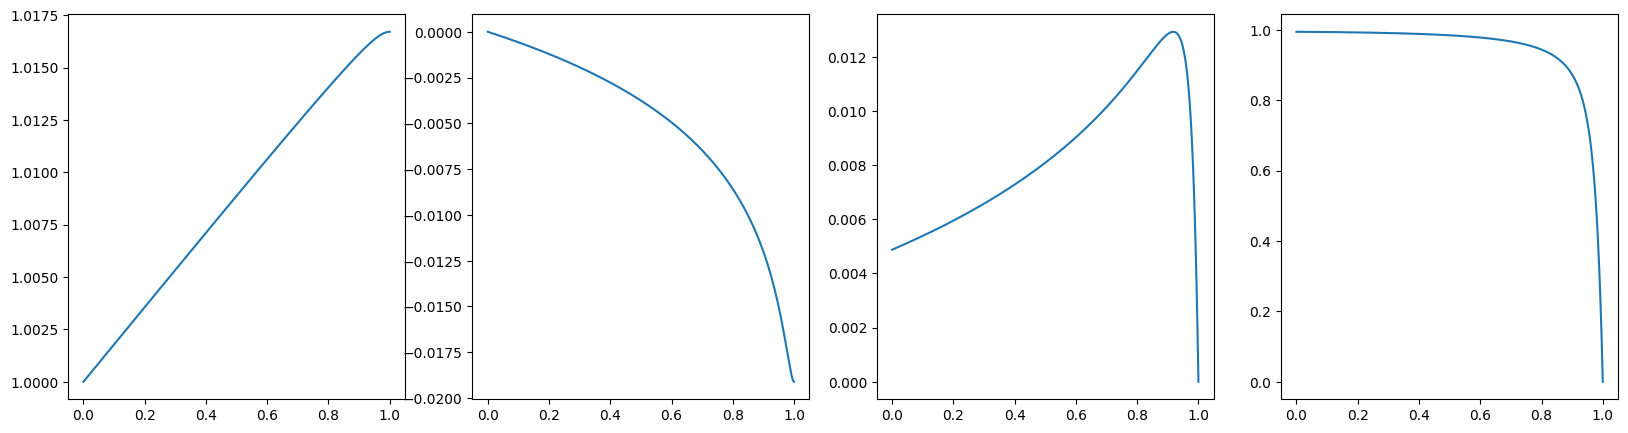

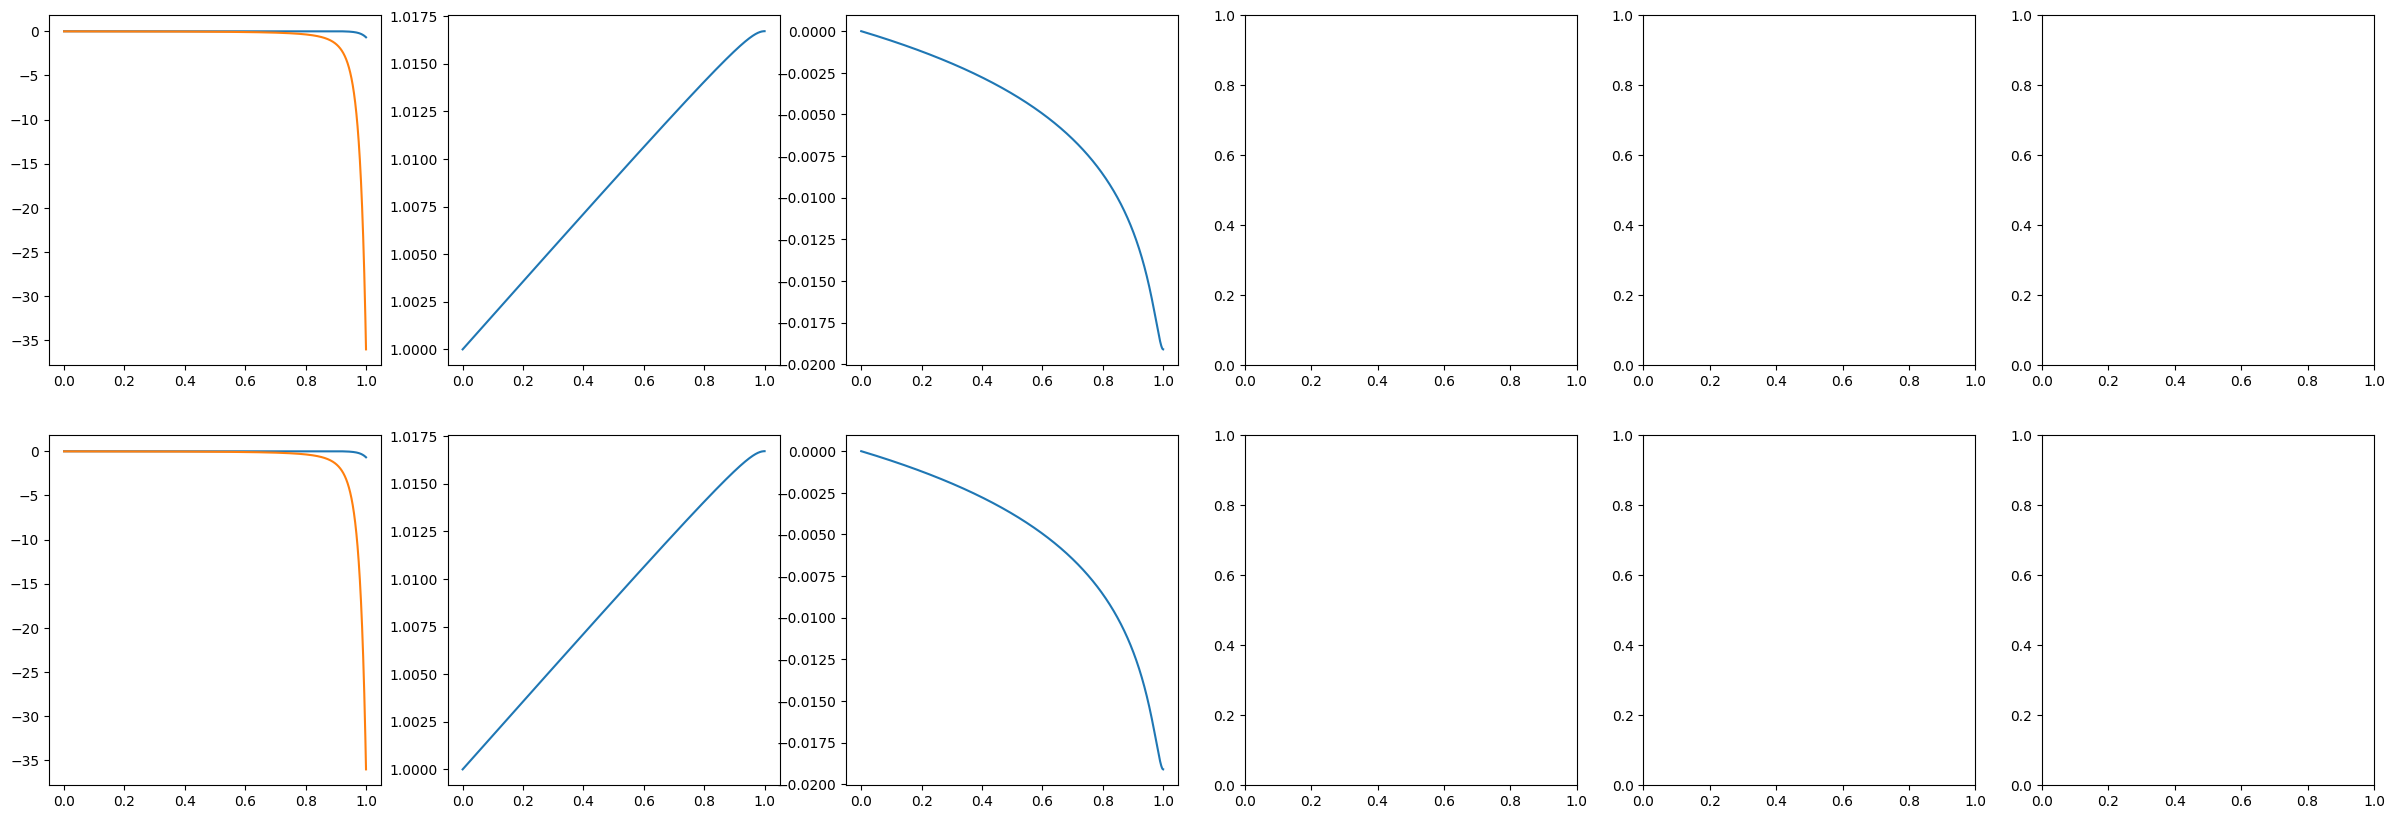

In [101]:
x_x = sol.x
dz_x, u_x = sol.y 
dzc_x = real(dz_x)
dzs_x = imag(dz_x)
uc_x = real(u_x)
us_x = imag(u_x)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].plot(x_x, dzc_x)
axs[1].plot(x_x, dzs_x)
axs[2].plot(x_x, uc_x)
axs[3].plot(x_x, us_x)
plt.show()

h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)

# helper functions that often appear
s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

s1_x_dxx = -4 / pi**0.5 / a_r * (h_x_dxx * s2_x + h_x_dx * s2_x_dx)
s2_x_dxx = 8 / a_r**2 * (h_x_dxx * (1-h_x) * s2_x - h_x_dx  * h_x_dx * s2_x + h_x_dx * (1-h_x) * s2_x_dx)

# leading order
eta0_x = 0.5 * (1 + s1_x)
eta0_x_dx = 0.5 * s1_x_dx
Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx
Y0_x_dxx = 0.5 * (s1_x_dxx * (1 - h_x) - s1_x_dx * h_x_dx - s1_x_dx * h_x_dx - (s1_x + 1) * h_x_dxx) + a_r / 4 / pi**0.5 * s2_x_dxx

dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)
u_x_dx = (-1j * eta0_x * dz_x - u_x * Y0_x_dx)  / Y0_x

fig, axs = plt.subplots(2, 6, figsize=(30, 10))
axs[0, 0].plot(x_x, real(u_x_dx))
axs[0, 0].plot(x_x, imag(u_x_dx))
axs[0, 1].plot(x_x, real(dz_x))
axs[0, 2].plot(x_x, imag(dz_x))

u_x_dx2 = (- eta0_x * 1j * dz_x - Y0_x_dx * u_x ) / Y0_x
dz_x2 = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x

axs[1, 0].plot(x_x, real(u_x_dx2))
axs[1, 0].plot(x_x, imag(u_x_dx2))
axs[1, 1].plot(x_x, real(dz_x2))
axs[1, 2].plot(x_x, imag(dz_x2))

plt.show()




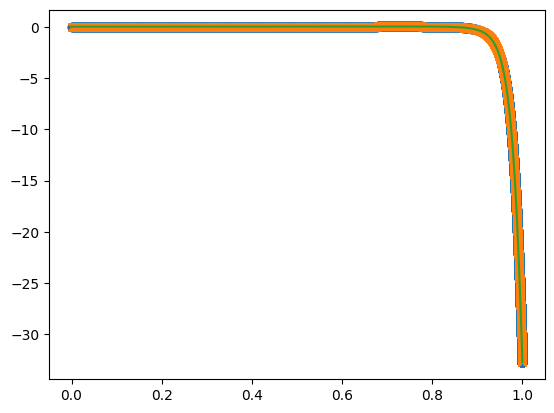

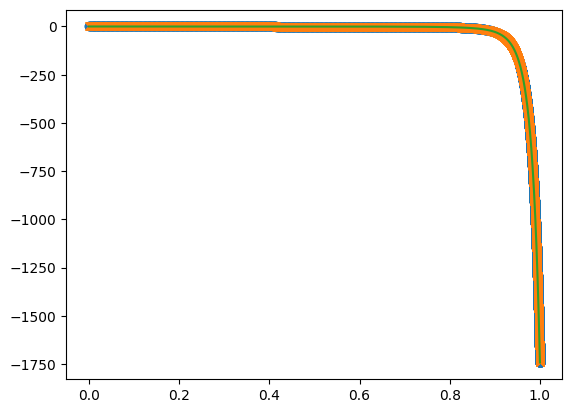

[0.01410694 0.01410669 0.01410645 0.01410621 0.01410596 0.01410572
 0.01410547 0.01410523 0.01410498 0.01410474]


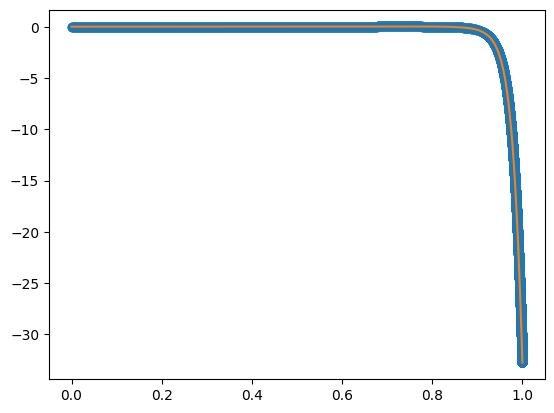

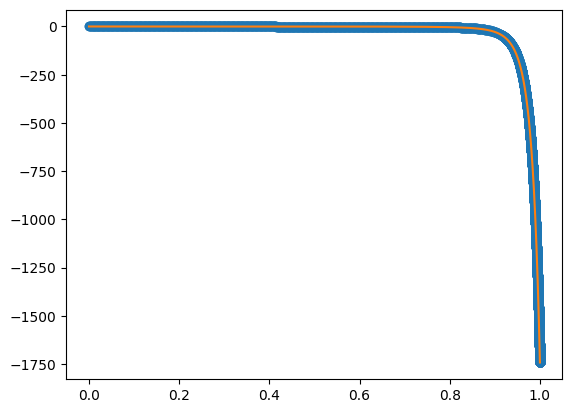

In [102]:
# complex system of equations:

 


def deriv(x_x, y_x):
    h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)

    # helper functions that often appear
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    s1_x_dxx = -4 / pi**0.5 / a_r * (h_x_dxx * s2_x + h_x_dx * s2_x_dx)
    s2_x_dxx = 8 / a_r**2 * (h_x_dxx * (1-h_x) * s2_x - h_x_dx  * h_x_dx * s2_x + h_x_dx * (1-h_x) * s2_x_dx)

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx
    Y0_x_dxx = 0.5 * (s1_x_dxx * (1 - h_x) - s1_x_dx * h_x_dx - s1_x_dx * h_x_dx - (s1_x + 1) * h_x_dxx) + a_r / 4 / pi**0.5 * s2_x_dxx

    u_x, u_x_dx = y_x

    dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x

    # dz_x_dx2 = 1j * (Y0_x_dxx * u_x + Y0_x_dx * u_x_dx + Y0_x_dx + u_x_dx + Y0_x * u_x_dxx) / eta0_x - 1j / eta0_x**2 * eta0_x_dx * (Y0_x_dx * u_x + Y0_x * u_x_dx) 
    dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)

    u_x_dxx2 = 1 / Y0_x**2 * (
        -1j*eta0_x_dx * Y0_x * dz_x
        -1j*eta0_x * Y0_x * dz_x_dx
        + 1j * eta0_x * Y0_x_dx * dz_x
        -Y0_x * Y0_x_dxx * u_x
        -Y0_x * Y0_x_dx * u_x_dx
        + u_x * Y0_x_dx * Y0_x_dx
    )

    u_x_dxx = -1j * (
        eta0_x_dx * dz_x / Y0_x +
        eta0_x * dz_x_dx / Y0_x +
        - eta0_x * dz_x * Y0_x_dx / Y0_x**2
    ) - (
        Y0_x_dxx * u_x / Y0_x + 
        Y0_x_dx * u_x_dx / Y0_x +
        - u_x * (Y0_x_dx / Y0_x)**2
    )



    plt.plot(x_x, real(u_x_dxx), 'o')
    plt.plot(x_x, real(u_x_dxx2), 'x')
    plt.plot(x_x, real(np.gradient(u_x_dx, x_x)))
    plt.show()

    plt.plot(x_x, imag(u_x_dxx), 'o')
    plt.plot(x_x, imag(u_x_dxx2), 'x')
    plt.plot(x_x, imag(np.gradient(u_x_dx, x_x)))
    plt.show()

    return [u_x_dx, u_x_dxx]



u_x_dx_g, u_x_dxx_g = deriv(x_x, [u_x, u_x_dx])

print(Y0_x[-10::])
# plt.plot(x_x, Y0_x)
# plt.show()
plt.plot(x_x, real(u_x_dxx_g), 'o')
plt.plot(x_x, real(np.gradient(u_x_dx, x_x)))
plt.show()

plt.plot(x_x, imag(u_x_dxx_g), 'o')
plt.plot(x_x, imag(np.gradient(u_x_dx, x_x)))
plt.show()

In [ ]:
# complex system of equations:

def deriv(x_x, y_x):
    h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)

    # helper functions that often appear
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    s1_x_dxx = -4 / pi**0.5 / a_r * (h_x_dxx * s2_x + h_x_dx * s2_x_dx)
    s2_x_dxx = 8 / a_r**2 * (h_x_dxx * (1-h_x) * s2_x - h_x_dx  * h_x_dx * s2_x + h_x_dx * (1-h_x) * s2_x_dx)

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx
    Y0_x_dxx = 0.5 * (s1_x_dxx * (1 - h_x) - s1_x_dx * h_x_dx - s1_x_dx * h_x_dx - (s1_x + 1) * h_x_dxx) + a_r / 4 / pi**0.5 * s2_x_dxx

    u_x, u_x_dx = y_x

    dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x

    # dz_x_dx2 = 1j * (Y0_x_dxx * u_x + Y0_x_dx * u_x_dx + Y0_x_dx + u_x_dx + Y0_x * u_x_dxx) / eta0_x - 1j / eta0_x**2 * eta0_x_dx * (Y0_x_dx * u_x + Y0_x * u_x_dx) 
    dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)


    u_x_dxx = -1j * (
        eta0_x_dx * dz_x / Y0_x +
        eta0_x * dz_x_dx / Y0_x +
        - eta0_x * dz_x * Y0_x_dx / Y0_x**2
    ) - (
        Y0_x_dxx * u_x / Y0_x + 
        Y0_x_dx * u_x_dx / Y0_x +
        - Y0_x_dx * u_x * Y0_x_dx / Y0_x**2
    )

    return [u_x_dx, u_x_dxx]


def bc(y_l, y_r):
    u_l, u_l_dx = y_l
    u_r, u_r_dx = y_r

    h_x, h_x_dx, h_x_dxx = h_fx(0), h_fx_dx(0), h_fx_dxx(0)

    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx


    dz_l = 1j * (Y0_x_dx * u_l + Y0_x * u_l_dx) / eta0_x

    return [dz_l - 1, u_r]

x_x = np.linspace(0, 1, 1000)
y_guess = 0.1 * np.ones((2, len(x_x))) + 0.1j * np.ones((2, len(x_x)))

sol = scipy.integrate.solve_bvp(deriv, bc, x_x, y_guess, tol=1e-3, max_nodes=20000, verbose=2)
x = sol.x


# dz_x, u_x = sol.y 


# dzc_x = real(dz_x)
# dzs_x = imag(dz_x)
# uc_x = real(u_x)
# us_x = imag(u_x)


# fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# axs[0].plot(x, dzc_x)
# axs[1].plot(x, dzs_x)
# axs[2].plot(x, uc_x)
# axs[3].plot(x, us_x)
# plt.show()


   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.14e-01       7.72e-01         1000           1955      
       2          7.00e-01       5.97e-01         2955           5724      
       3          7.15e-01       4.61e-01         8679          (15978)    
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 7.15e-01 
Maximum boundary residual: 4.61e-01


ValueError: x and y must have same first dimension, but have shapes (1000,) and (16121,)

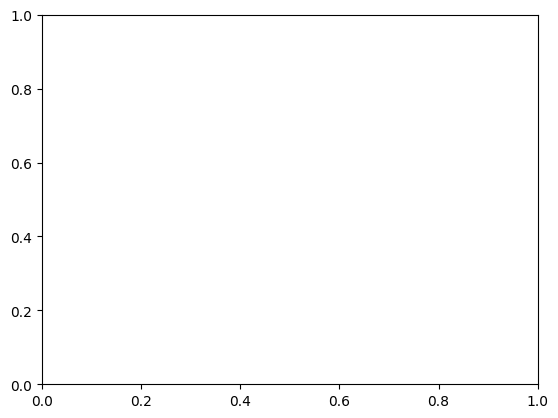

In [104]:
plt.plot(x_x, np.gradient(Y0_x_dx))
plt.show()